In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

In [5]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [6]:
y_data = pd.read_csv("Target.csv", usecols=[6])
y_data

,FE EtOH
0,7.587686
1,10.061535
2,6.674688
3,11.587396
4,13.044772
...,...
77,18.137629
78,22.497833
79,17.296025
80,12.612181


In [7]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [8]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # Obtain the normalized function model through the training set, and use the x_train data to calculate the minimum and maximum values ​​required by the scaler
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)# Use the fitted scaler to scale the x_train data
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [9]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5-fold cross validation
#mse It measures the average of the squares of the differences between the predicted values ​​and the actual values. The smaller the mean square error, the better the predictive performance of the model
variate=list(range(x_train.shape[1]))   #Variable index list
selected=[]   #Variable index
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#The current score of the validation set and the initial value of the best score are both infinite (because the smaller the mse, the better)
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#Loop through variables
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #Iterate over the arguments one by one
        current_variate = selected+[i]   #Current variables
        current_x_train = x_train[:, current_variate]   #current x_train
        current_x_test = x_test[:, current_variate]   #current x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #Remove the added variable name, that is, in the second loop, this independent variable is not considered
    selected.append(best_candidate_index)  #Add this variable as an independent variable to the model
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #Remove the added variable name, that is, in the second loop, this independent variable is not considered
            #selected.append(best_candidate_index)  #Add this variable as an independent variable to the model
            #current_score = best_new_score  #The latest score is equal to the best score
            #print("score is {},continuing!".format(current_score))  #Output the minimum mse value
        #else:
            #print("for selection over!")
            #break

In [19]:
selected

[175,
 263,
 301,
 146,
 123,
 303,
 247,
 216,
 262,
 177,
 97,
 152,
 258,
 293,
 162,
 118,
 259,
 96,
 0,
 238,
 128,
 170,
 32,
 92,
 244,
 10,
 52,
 91,
 59,
 28,
 27,
 151,
 147,
 57,
 17,
 269,
 51,
 76,
 44,
 255,
 99,
 180,
 296,
 94,
 139,
 1,
 2,
 4,
 6,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 113,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 183,
 55,
 130,
 19,
 21,
 242,
 45,
 273,
 3,
 25,
 153,
 48,
 29,
 121,
 236,
 129,
 89,
 249,
 163,
 14,
 240,
 275,
 161,
 251,
 117,
 142,
 231,
 198,
 112,
 72,
 137,
 226,
 246,
 241,
 176,
 58,
 192,
 169,
 279,
 42,
 220,
 295,
 250,
 24,
 144,
 73,
 108,
 61,
 167,
 174,
 234,
 181,
 239,
 116,
 245,
 289,
 98,
 158,
 179,
 134,
 305,
 221,
 195,
 248,
 95,
 227,
 193,
 124,
 196,
 173,
 284,
 136,
 166,
 50,
 190,
 184,
 31,
 291,
 84,
 252,
 282,
 185,
 87,
 81,
 217,
 187,
 165,
 243,
 78,
 237,
 70,
 75,
 260,
 66,
 68,
 254,
 67,
 77,
 90,
 69,
 150,
 155,
 229,
 253,
 267,
 276,
 80,
 278,
 23

In [20]:
train_mse_list

[0.032067868394971236,
 0.022648279422444514,
 0.02020463376565179,
 0.01623987984747106,
 0.017122266327487926,
 0.013740747074565938,
 0.01309858707040563,
 0.01312627929122108,
 0.012474761872449057,
 0.01168754798834482,
 0.012184969012081603,
 0.011572051989623394,
 0.01094304771258824,
 0.011506193314117683,
 0.011480733312639402,
 0.011737025640067582,
 0.011727289174307813,
 0.012057748120625688,
 0.012336055728226682,
 0.012289654100264486,
 0.012315150979336758,
 0.011790181766251238,
 0.011455337730296278,
 0.011310167934020388,
 0.011414686343395158,
 0.01140505145916438,
 0.01148994188854403,
 0.011353804870682048,
 0.011455419930655962,
 0.011377620969726474,
 0.011350160986066084,
 0.01135695067241225,
 0.011350495930628372,
 0.01131645089099718,
 0.01135204692110697,
 0.011283254522766982,
 0.011343747997853386,
 0.011230203718843697,
 0.011270063378086653,
 0.011110192023478741,
 0.011161765622562308,
 0.011202287719028061,
 0.01113305541547823,
 0.011284327950307291,


In [21]:
val_mse_list

[0.037172347087494444,
 0.031340165597927835,
 0.02641891950192632,
 0.02710742015846392,
 0.026620038047732754,
 0.026036123225274765,
 0.02410207398246702,
 0.023925548092855554,
 0.024116157468629596,
 0.023606417178144837,
 0.022344809960004323,
 0.02215357601680746,
 0.02154834421533722,
 0.020943063387185552,
 0.020504973735912615,
 0.02053235516661532,
 0.020466443056548912,
 0.020585454898577778,
 0.020740981184975877,
 0.02088629617432162,
 0.020787667485296542,
 0.020651180810925603,
 0.020376987474860383,
 0.02018541124834102,
 0.019991666636183562,
 0.019907534915530996,
 0.019803792167838553,
 0.01973360812545878,
 0.01966772334316297,
 0.019592408052642833,
 0.019604113366854945,
 0.01956575135368387,
 0.019430146693943422,
 0.01937833519865859,
 0.01939786067938302,
 0.019419959488638238,
 0.01942674719758363,
 0.019461633219106156,
 0.019507250563084083,
 0.019528190672802516,
 0.019572297394994942,
 0.01962578484279174,
 0.019674655822431907,
 0.01967124435847344,
 0.0

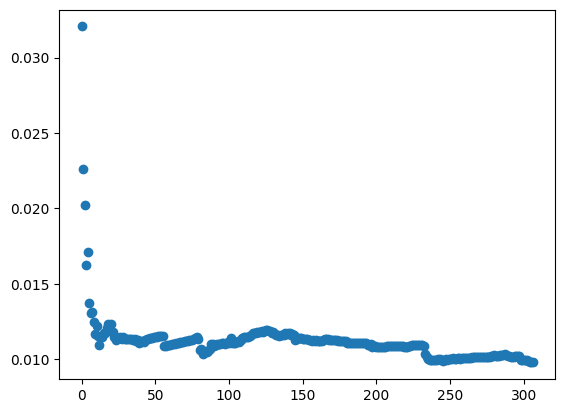

In [22]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

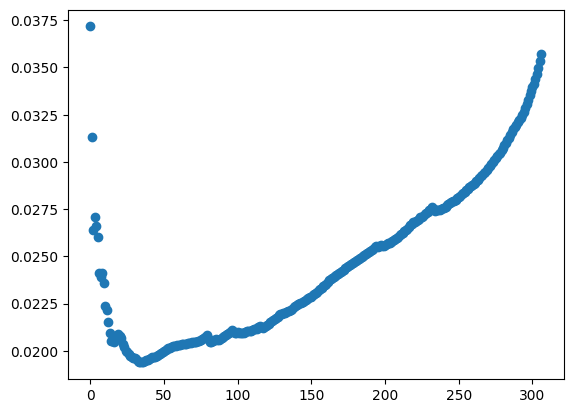

In [23]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [11]:
min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

33
0.01937833519865859


In [13]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Conju-Part-Wt (Max-Conju)
Long/Sum Size Ratio
Atom1_ESP Maximal value (kcal/mol)
VSA_EState7
SlogP_VSA4
Atom1_ESP Pi (kcal/mol)
Conju_LogP_Min
Mid-Fun_PEOE-Charge_Sum
Molecular Size Long
Max Conju-Distance (Max-Conju)
PEOE_VSA12
NOCount
Farthest Distance
ALIE Minimal Value
NumRotatableBonds
SlogP_VSA10
Molecular Radius
PEOE_VSA11
c1nc_nH_n1
Conju_LogP_Mean
TPSA
Num of Conju-All-Atoms
Disulfide
Kappa3
Conju_LogP_Max
c1ccc2occcc2c1
Arylbromide
Kappa2
Sulfonic_derivative
Secondary_arom_amine
Primary_arom_amine
NHOHCount
VSA_EState8
Nitro


In [38]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
# Specify the path where the image is saved
import os
save_dir = 'Selected features'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
data = x_data[selected_columns]
# Save the selected data as a CSV file
output_file = os.path.join(save_dir, "selected_features-EtOH.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Conju-Part-Wt (Max-Conju),Long/Sum Size Ratio,Atom1_ESP Maximal value (kcal/mol),VSA_EState7,SlogP_VSA4,Atom1_ESP Pi (kcal/mol),Conju_LogP_Min,Mid-Fun_PEOE-Charge_Sum,Molecular Size Long,Max Conju-Distance (Max-Conju),PEOE_VSA12,NOCount,Farthest Distance,ALIE Minimal Value,NumRotatableBonds,SlogP_VSA10,Molecular Radius,PEOE_VSA11,c1nc_nH_n1,Conju_LogP_Mean,TPSA,Num of Conju-All-Atoms,Disulfide,Kappa3,Conju_LogP_Max,c1ccc2occcc2c1,Arylbromide,Kappa2,Sulfonic_derivative,Secondary_arom_amine,Primary_arom_amine,NHOHCount,VSA_EState8,Nitro
0,108.121,0.491618,90.133446,0.000000,0.0,13.207422,0.6122,7.436550e-01,10.674,4,0.0,3,8.294,9.85838,2,0.0,5.507,5.783245,0,0.6122,57.53,7,0,1.891911,0.6122,0,0,3.169016,0,0,0,2,1.443818,0
1,160.015,0.449793,69.205496,0.000000,0.0,12.774025,2.5106,-4.160000e-17,8.372,3,0.0,0,5.355,9.73413,0,0.0,4.202,0.000000,0,2.5106,0.00,6,0,0.819939,2.5106,0,1,1.755632,0,0,0,0,0.000000,0
2,44.009,0.399801,74.758819,0.000000,0.0,14.830128,-0.4222,-1.879163e-01,7.242,2,0.0,2,4.083,8.76834,1,0.0,3.401,0.000000,0,-0.4222,37.30,3,0,3.820000,-0.4222,0,0,2.081780,0,0,0,1,0.000000,0
3,44.009,0.483168,78.529901,0.259401,0.0,15.026383,-0.4222,-4.545539e-01,12.214,2,0.0,4,9.190,8.50923,7,0.0,6.115,0.000000,0,-0.4222,74.60,6,1,9.640000,-0.4222,0,0,7.297763,0,0,0,2,0.000000,0
4,24.022,0.527381,31.069320,3.793981,0.0,14.378481,0.6792,-3.857851e-02,11.566,1,0.0,0,9.166,7.85309,4,0.0,5.783,0.000000,0,0.6792,0.00,4,0,5.830000,0.6792,0,0,5.830000,0,0,0,0,7.154722,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.000,0.660614,42.573869,10.967467,0.0,13.985197,0.0000,-1.543219e-01,18.445,0,0.0,0,15.453,8.02673,9,0.0,9.227,0.000000,0,0.0000,0.00,0,0,10.700000,0.0000,0,0,11.700000,0,0,0,0,0.000000,0
78,0.000,0.625620,43.318557,8.044435,0.0,14.029267,0.0000,-1.543219e-01,15.882,0,0.0,0,12.895,8.02737,7,0.0,7.947,0.000000,0,0.0000,0.00,0,0,8.700000,0.0000,0,0,9.700000,0,0,0,0,0.000000,0
79,0.000,0.569067,45.745684,3.764228,0.0,14.192581,0.0000,-1.543219e-01,12.050,0,0.0,0,9.099,8.03568,4,0.0,6.049,0.000000,0,0.0000,0.00,0,0,6.700000,0.0000,0,0,6.700000,0,0,0,0,0.000000,0
80,0.000,0.530080,48.501562,2.402006,0.0,14.306475,0.0000,-1.543209e-01,10.732,0,0.0,0,7.776,8.04913,3,0.0,5.388,0.000000,0,0.0000,0.00,0,0,4.700000,0.0000,0,0,5.700000,0,0,0,0,0.000000,0


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate on the test set using the best selected variable
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# Keep two decimal places
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# Create a save directory
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
output_file1 = os.path.join(save_dir, "final_evaluation-EtOH.csv")
# Save test set evaluation results to CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Conju-Part-Wt (Max-Conju)', 'Long/Sum Size Ratio', 'Atom1_ESP Maximal value (kcal/mol)', 'VSA_EState7', 'SlogP_VSA4', 'Atom1_ESP Pi (kcal/mol)', 'Conju_LogP_Min', 'Mid-Fun_PEOE-Charge_Sum', 'Molecular Size Long', 'Max Conju-Distance (Max-Conju)', 'PEOE_VSA12', 'NOCount', 'Farthest Distance', 'ALIE Minimal Value', 'NumRotatableBonds', 'SlogP_VSA10', 'Molecular Radius', 'PEOE_VSA11', 'c1nc_nH_n1', 'Conju_LogP_Mean', 'TPSA', 'Num of Conju-All-Atoms', 'Disulfide', 'Kappa3', 'Conju_LogP_Max', 'c1ccc2occcc2c1', 'Arylbromide', 'Kappa2', 'Sulfonic_derivative', 'Secondary_arom_amine', 'Primary_arom_amine', 'NHOHCount', 'VSA_EState8', 'Nitro']
Test MSE: 0.0549
Test R2: -0.0652
Results saved to 'Test mse after svr/final_evaluation-EtOH.csv'
